# Analyse der Webanwendung  "PetClinic"  
   
   

## _Priorisierung von Umbauarbeiten nach Nutzungsgrad_


## Einlesen der Nutzungsstatistiken

In [1]:
import pandas as pd

coverage = pd.read_csv("../dataset/jacoco.csv")
coverage = coverage[
                ['PACKAGE',
                 'CLASS',
                 'LINE_COVERED',
                 'LINE_MISSED']]
coverage.head()

,PACKAGE,CLASS,LINE_COVERED,LINE_MISSED
0,org.springframework.samples.petclinic,PetclinicInitializer,24,0
1,org.springframework.samples.petclinic.model,NamedEntity,4,1
2,org.springframework.samples.petclinic.model,Specialty,1,0
3,org.springframework.samples.petclinic.model,PetType,1,0
4,org.springframework.samples.petclinic.model,Vets,0,4


### Berechnung zusätzlicher Messwerte und Schlüssel

In [2]:
coverage['lines'] = coverage.LINE_COVERED + coverage.LINE_MISSED
coverage['ratio'] = coverage.LINE_COVERED / coverage.lines
coverage['fqn'] = coverage.PACKAGE + "." + coverage.CLASS
coverage[['fqn', 'ratio']].head()

,fqn,ratio
0,org.springframework.samples.petclinic.Petclini...,1.0
1,org.springframework.samples.petclinic.model.Na...,0.8
2,org.springframework.samples.petclinic.model.Sp...,1.0
3,org.springframework.samples.petclinic.model.Pe...,1.0
4,org.springframework.samples.petclinic.model.Vets,0.0


### Laden der Daten in die Graphdatenbank

In [3]:
import py2neo
graph = py2neo.Graph()

query="""
    UNWIND {coverage_data} as coverage
    MATCH (t:Type {fqn : coverage.fqn})
    MERGE (t)-[:HAS_MEASURE]->(m)
    SET 
        m:Measure:Coverage, 
        m.ratio = coverage.ratio
    RETURN t.fqn as fqn, m.ratio as ratio
"""
coverage_dict = coverage.to_dict(orient='records')
result = graph.run(query, coverage_data=coverage_dict).data()
pd.DataFrame(result).head()

,fqn,ratio
0,org.springframework.samples.petclinic.Petclini...,1.0
1,org.springframework.samples.petclinic.model.Na...,0.8
2,org.springframework.samples.petclinic.model.Sp...,1.0
3,org.springframework.samples.petclinic.model.Vets,0.0
4,org.springframework.samples.petclinic.model.Visit,1.0


## Aggregation der Messwerte nach Subdomänen

In [4]:
query = """
MATCH 
  (t:Type)-[:BELONGS_TO]->(s:Subdomain),
  (t)-[:HAS_CHANGE]->(ch:Change),
  (t)-[:HAS_MEASURE]->(co:Coverage)
OPTIONAL MATCH
  (t)-[:HAS_BUG]->(b:BugInstance)
RETURN 
  s.name as ASubdomain,
  COUNT(DISTINCT t) as Types,
  COUNT(DISTINCT ch) as Changes,
  AVG(co.ratio) as Coverage,
  COUNT(DISTINCT b) as Bugs,
  SUM(DISTINCT t.lastMethodLineNumber) as Lines
ORDER BY Coverage ASC, Bugs DESC
"""

### Ergebnisse nach Subdomänen

In [5]:
result = pd.DataFrame(graph.run(query).data())
result

,ASubdomain,Bugs,Changes,Coverage,Lines,Types
0,Vet,0,75,0.170000,313,5
1,Visit,0,90,0.368056,472,6
2,Pet,1,162,0.467011,718,10
3,Owner,4,98,0.535399,531,4
4,crossfunctional,2,57,0.569953,268,5
5,Clinic,0,19,0.888889,115,1
6,Person,0,5,1.000000,53,1
7,Specialty,0,5,1.000000,28,1


### Umbenennung nach geläufigen Begriffen

In [6]:
plot_data = result.copy().set_index('ASubdomain')
plot_data = plot_data.rename(
    columns= {
        "Changes" : "Investment",
        "Coverage" : "Utilization",
        "Lines" : "Size"})
plot_data

,Bugs,Investment,Utilization,Size,Types
ASubdomain,,,,,
Vet,0,75,0.170000,313,5
Visit,0,90,0.368056,472,6
Pet,1,162,0.467011,718,10
Owner,4,98,0.535399,531,4
crossfunctional,2,57,0.569953,268,5
Clinic,0,19,0.888889,115,1
Person,0,5,1.000000,53,1
Specialty,0,5,1.000000,28,1


In [7]:
%matplotlib inline
from ausi.portfolio import plot_diagram

### Vier-Felder-Matrix zur Priorisierung nach Subdomänen

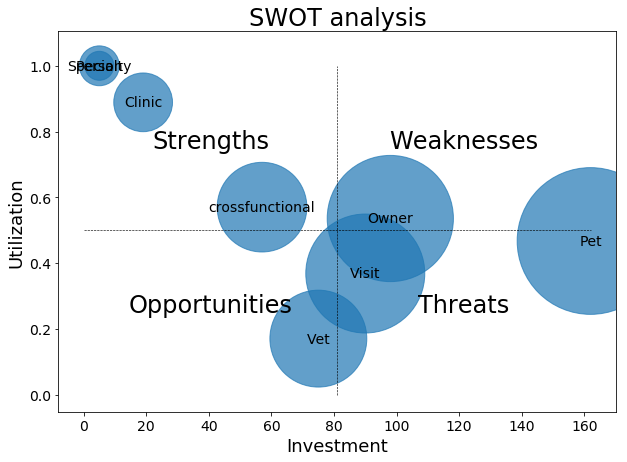

In [8]:
plot_diagram(plot_data, 'Investment', 'Utilization', 'Size');

## Aggregation der Messwerte nach technischen Aspekten

In [9]:
query = """
MATCH 
  (t:Type)-[:IS_A]->(ta:TechnicalAspect),
  (t)-[:HAS_CHANGE]->(ch:Change),
  (t)-[:HAS_MEASURE]->(co:Coverage)
OPTIONAL MATCH
  (t)-[:HAS_BUG]->(b:BugInstance)   
RETURN 
  ta.name as ATechnicalAspect,
  COUNT(DISTINCT t) as Types,
  COUNT(DISTINCT ch) as Investment,
  AVG(co.ratio) as Utilization,
  COUNT(DISTINCT b) as Bugs,
  SUM(DISTINCT t.lastMethodLineNumber) as Size
ORDER BY Utilization ASC, Bugs DESC
"""

### Ergebnisse nach technischen Aspekten

In [10]:
result = pd.DataFrame(graph.run(query).data()).set_index('ATechnicalAspect')
result

,Bugs,Investment,Size,Types,Utilization
ATechnicalAspect,,,,,
jdbc,1,155,643,8,0.000000
util,2,27,144,2,0.369919
web,3,156,576,7,0.623609
jpa,0,55,188,4,0.705313
model,1,86,669,9,0.709884
service,0,19,115,1,0.888889
petclinic,0,6,110,1,1.000000


### Vier-Felder-Matrix zur Priorisierung nach technischen Aspekten

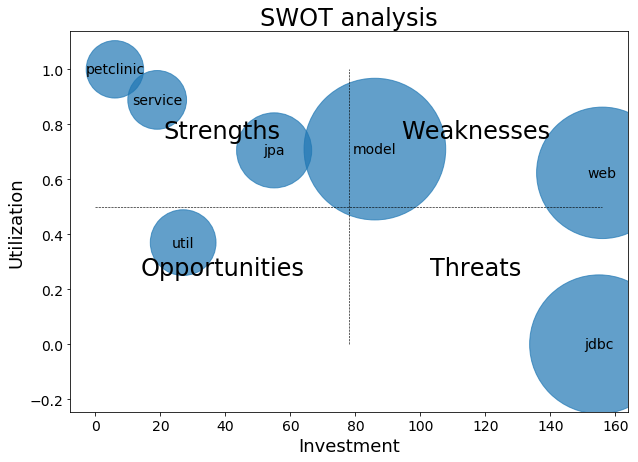

In [11]:
plot_diagram(result, 'Investment', 'Utilization', 'Size');

## Ende Demo